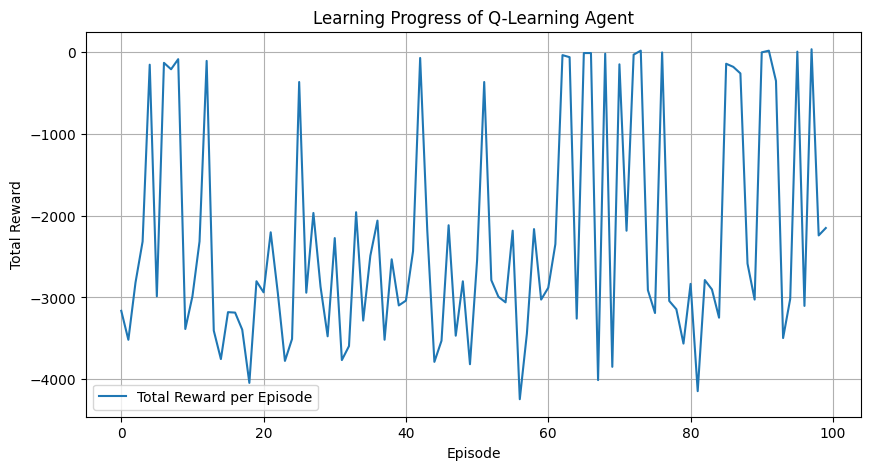

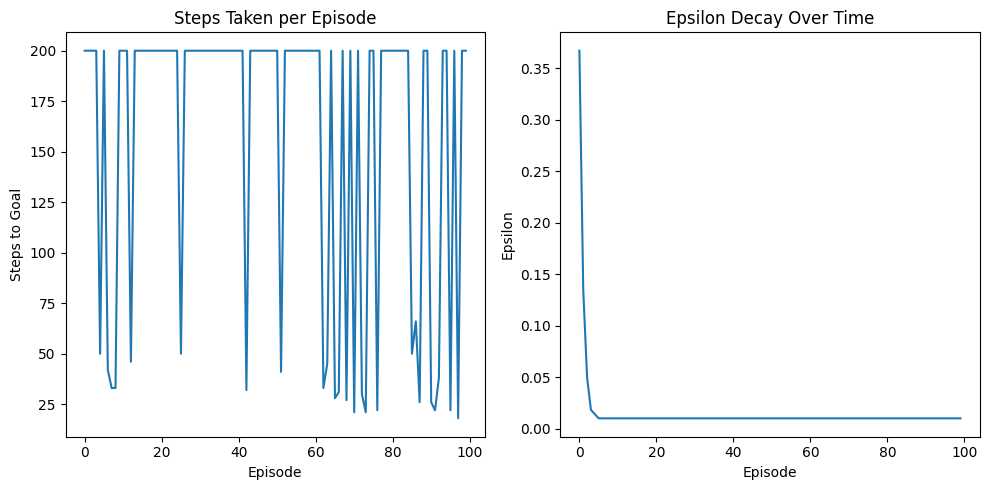

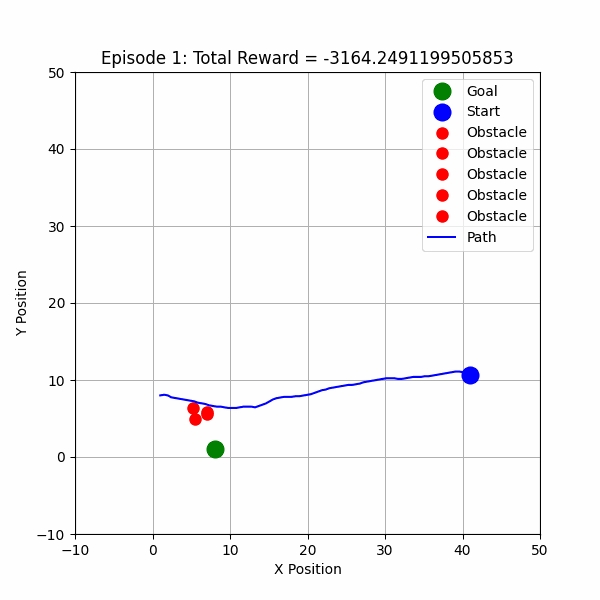

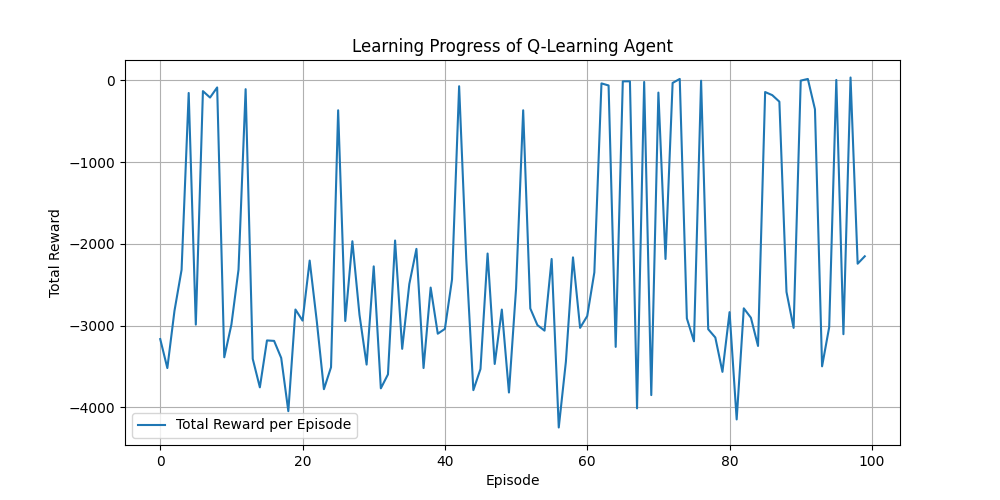

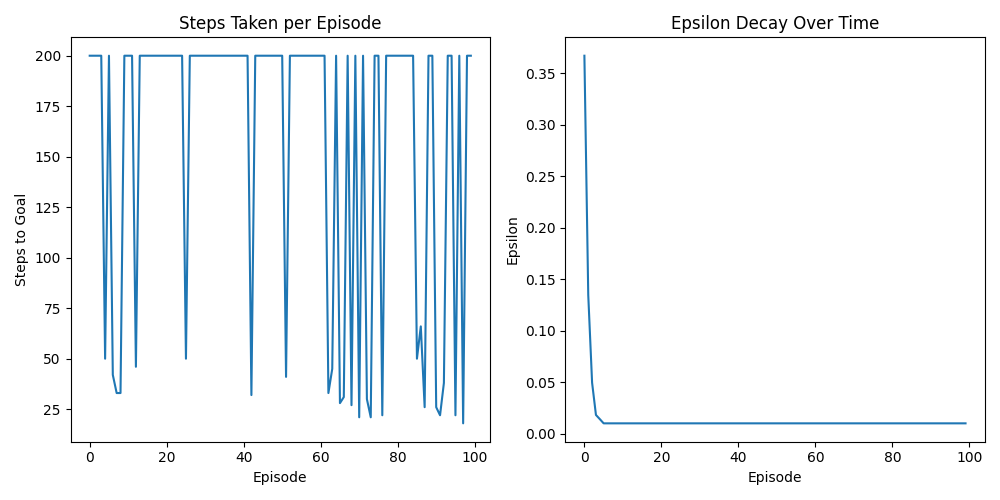

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the SimpleDrivingEnv environment with complex obstacles and multiple start/goal positions
class SimpleDrivingEnv:
    def __init__(self):
        # Multiple start and goal positions
        self.start_positions = [np.array([0.0, 0.0]), np.array([2.0, 2.0]), np.array([1.0, 8.0])]
        self.goal_positions = [np.array([10.0, 10.0]), np.array([8.0, 1.0]), np.array([7.0, 7.0])]
        self.obstacles = self.generate_complex_obstacles()
        self.done = False

    def generate_complex_obstacles(self):
        obstacles = []
        for _ in range(5):  # Generate 5 obstacles
            obstacle_type = random.choice(['random', 'circular', 'oscillating', 'linear'])
            x, y = np.random.uniform(1, 8), np.random.uniform(1, 8)
            obstacles.append({'position': np.array([x, y]), 'type': obstacle_type, 'velocity': np.random.uniform(-0.1, 0.1)})
        return obstacles

    def reset(self):
        # Randomly select a start and goal position for each episode
        self.car_position = random.choice(self.start_positions).copy()
        self.goal_position = random.choice(self.goal_positions).copy()
        self.car_angle = 0.0
        self.done = False
        return self._get_discrete_state()

    def _get_discrete_state(self):
        pos_x = int(self.car_position[0] // 2)  # Bin x position
        pos_y = int(self.car_position[1] // 2)  # Bin y position
        angle = int(self.car_angle // 45)       # Bin angle into 8 directions (45-degree intervals)
        return (pos_x, pos_y, angle)

    def check_collision(self):
        # Check if car collides with any obstacle
        for obstacle in self.obstacles:
            if np.linalg.norm(self.car_position - obstacle['position']) < 0.5:
                return True
        return False

    def update_obstacles(self):
        for obstacle in self.obstacles:
            if obstacle['type'] == 'random':
                obstacle['position'] += np.random.uniform(-0.05, 0.05, size=2)
            elif obstacle['type'] == 'circular':
                angle = np.random.uniform(0, 2 * np.pi)
                obstacle['position'] += np.array([np.cos(angle), np.sin(angle)]) * 0.2
            elif obstacle['type'] == 'oscillating':
                obstacle['position'][0] += np.sin(np.pi / 20) * 0.1
            elif obstacle['type'] == 'linear':
                obstacle['position'][0] += obstacle['velocity']

    def step(self, action):
        # Apply the chosen action
        if action == 0:  # Move forward
            rad_angle = np.deg2rad(self.car_angle)
            self.car_position += np.array([np.cos(rad_angle), np.sin(rad_angle)]) * 0.5
        elif action == 1:  # Turn left
            self.car_angle = (self.car_angle + 10) % 360
        elif action == 2:  # Turn right
            self.car_angle = (self.car_angle - 10) % 360

        self.update_obstacles()

        # Calculate reward and check for goal or collision
        distance_to_goal = np.linalg.norm(self.goal_position - self.car_position)
        reward = -distance_to_goal - 0.1  # Add small penalty for each step

        if self.check_collision():
            reward = -50
            self.done = True
        elif distance_to_goal < 1.0:
            reward = 100
            self.done = True

        next_state = self._get_discrete_state()
        return next_state, reward, self.done

    def render_path(self, path_positions, episode, total_reward):
        plt.figure(figsize=(6, 6))
        plt.plot(self.goal_position[0], self.goal_position[1], 'go', markersize=12, label="Goal")
        plt.plot(self.car_position[0], self.car_position[1], 'bo', markersize=12, label="Start")

        for obstacle in self.obstacles:
            plt.plot(obstacle['position'][0], obstacle['position'][1], 'ro', markersize=8, label="Obstacle")

        plt.plot([pos[0] for pos in path_positions], [pos[1] for pos in path_positions], 'b-', label="Path")
        plt.title(f"Episode {episode + 1}: Total Reward = {total_reward}")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.grid()
        plt.xlim(-10, 50)
        plt.ylim(-10, 50)

        filename = f"frames/episode_{episode + 1}.png"
        plt.savefig(filename)
        plt.close()

# Define Q-Learning Agent
class QLearningAgent:
    def __init__(self, action_size):
        self.q_table = {}
        self.learning_rate = 0.1
        self.discount_rate = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.action_size = action_size
        self.smoothing_factor = 0.1

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = [self.get_q_value(state, a) for a in range(self.action_size)]
        return np.argmax(q_values)

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax([self.get_q_value(next_state, a) for a in range(self.action_size)])
        td_target = reward + self.discount_rate * self.get_q_value(next_state, best_next_action)
        current_q = self.get_q_value(state, action)

        new_q = current_q + self.smoothing_factor * (td_target - current_q)
        self.q_table[(state, action)] = new_q

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize environment, agent, and visualization setup
os.makedirs("frames", exist_ok=True)
env = SimpleDrivingEnv()
agent = QLearningAgent(action_size=3)

# Training loop with multiple start/goal positions
n_episodes = 100
reward_log, epsilon_log, steps_log = [], [], []

for e in range(n_episodes):
    state = env.reset()
    total_reward, path_positions, steps_taken = 0, [], 0

    for t in range(200):
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)

        total_reward += reward
        path_positions.append(env.car_position.copy())
        steps_taken += 1

        state = next_state
        if done:
            break

    reward_log.append(total_reward)
    epsilon_log.append(agent.epsilon)
    steps_log.append(steps_taken)
    env.render_path(path_positions, e, total_reward)

# Generate GIF from episode frames
frames = [Image.open(f"frames/episode_{i+1}.png") for i in range(n_episodes)]
frames[0].save("training_simulation.gif", format="GIF", append_images=frames[1:], save_all=True, duration=200, loop=0)

# Plot reward over episodes
plt.figure(figsize=(10, 5))
plt.plot(range(n_episodes), reward_log, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Progress of Q-Learning Agent")
plt.legend()
plt.grid()
plt.savefig("reward_progress.png")
plt.show()

# Plotting steps and epsilon decay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_episodes), steps_log, label="Steps to Goal")
plt.xlabel("Episode")
plt.ylabel("Steps to Goal")
plt.title("Steps Taken per Episode")

plt.subplot(1, 2, 2)
plt.plot(range(n_episodes), epsilon_log, label="Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Time")

plt.tight_layout()
plt.savefig("steps_epsilon_progress.png")
plt.show()

# Display the generated GIF and reward plot in Jupyter or Colab
from IPython.display import Image as IPImage, display
display(IPImage(filename="training_simulation.gif"))
display(IPImage(filename="reward_progress.png"))
display(IPImage(filename="steps_epsilon_progress.png"))
